<a href="https://colab.research.google.com/github/Adabot123/NN/blob/main/WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [57]:
words = open('names.txt', 'r').read().splitlines()
print(words[:6])
print(len(words))
print(max(len(w) for w in words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']
32033
15


In [58]:
#building the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
print(itos)
vocab_size = len(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [59]:
import random
random.seed(42)
random.shuffle(words)

In [60]:
#building the dataset
block_size = 8

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size

    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X,Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [61]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [62]:
#layers
class Linear:

  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in, fan_out))/fan_in**0.5 #kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    #parameters (trained with backdrop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim = True) #batch mean
      xvar = x.var(dim, keepdim = True)

    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return[]

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n
  def __call__(self,x):
    B, T, C = x.shape
    x = x.view(B, -1, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [63]:
torch.manual_seed(42);

In [64]:
n_embd = 10 #dimensionality of the character embedding vectors
n_hidden = 68 #the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])
#parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) #numbers of parameters in total
for p in parameters:
  p.requires_grad = True

22127


In [65]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 11, 23,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 11,  9, 13],
        [ 0,  0,  0,  0,  0,  0,  0,  1]])

In [66]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [67]:
model.layers[0].out.shape #output of Embedding layer

torch.Size([4, 8, 10])

In [68]:
model.layers[1].out.shape #output of Flatten layer

torch.Size([4, 4, 20])

In [69]:
model.layers[2].out.shape #output of Linear layer

torch.Size([4, 4, 68])

In [70]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [71]:
(torch.randn(4,4,20) @ torch.randn (20,200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [72]:
# (1,2) (3,4) (5,6) (7,8)

In [73]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [74]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [75]:
e = torch.randn(4,8,10) #convert it into (4,4,20)
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2) #we are simply stacking them side by side
explicit.shape

torch.Size([4, 4, 20])

In [76]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

In [77]:
e[:1, ::2, :]


tensor([[[ 0.2409, -0.1325, -0.2073,  1.3115,  0.8920,  0.2639, -0.1151,
           0.1463, -0.4407,  0.5409],
         [-1.4353, -0.7023,  0.9318, -0.1063,  0.1351, -0.3039, -0.5068,
          -0.6150, -2.2113,  2.4876],
         [-1.0935,  1.1986,  0.5158,  0.7961,  0.0128, -1.0427,  0.4962,
          -1.0023,  0.6301,  1.3381],
         [-1.5922, -1.9878,  0.3993,  0.0870,  0.2826, -0.7896, -0.7771,
          -0.2361,  0.3211, -0.0708]]])

In [78]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

  #forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) #loss function

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update SGD
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/3.3065
  10000/2.4348
  20000/2.0977
  30000/2.2220
  40000/2.3536
  50000/2.0383
  60000/1.8373
  70000/2.3337
  80000/2.0633
  90000/2.3616
 100000/1.9101
 110000/1.9939
 120000/1.6899
 130000/2.1929
 140000/1.8150
 150000/2.1017
 160000/1.7229
 170000/1.9167
 180000/1.6260
 190000/2.0450


In [79]:
ix = torch.randint(0, Xtr.shape[0], (32,))
Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y
Yb.shape

torch.Size([32])

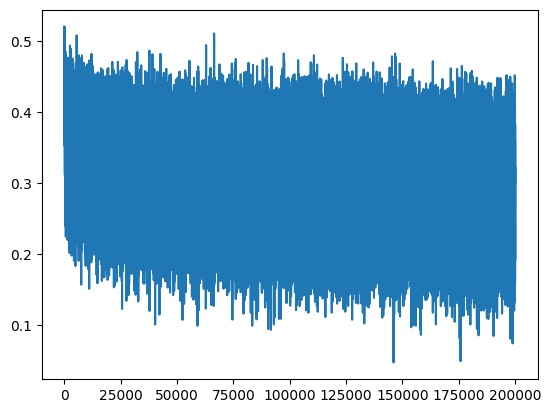

In [80]:
plt.plot(lossi)

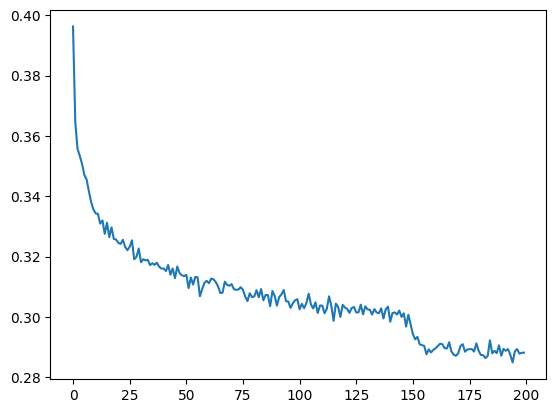

In [81]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [82]:
for layer in model.layers:
  layer.training = False

In [83]:
#evaluate the loss
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val':(Xdev, Ydev),
      'test': (Xte, Yte),
      }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
split_loss('train')
split_loss('val')


train 1.9215584993362427
val 2.0301079750061035


In [84]:
#sample from the model

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    #sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    #shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

ayive.
cata.
mataley.
peevell.
candrie.
livi.
kielesa.
mikoah.
makaiana.
zilyna.
sianna.
denzlea.
crittoston.
johean.
melas.
annali.
gilden.
rapland.
neuvi.
beroke.
